# DeFactify 📰 - Iteration 2

This notebook is dedicated to developing a `Fake News Detection system` using machine learning techniques.

Let's begin by importing the libraries and checking their versions.

In [2]:
import nltk
import numpy
import joblib
import pandas
import sklearn
import seaborn

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Library versions:")
print("- nltk:", nltk.__version__)              # 3.9.1
print("- numpy:", numpy.__version__)            # 2.1.3
print("- pandas:", pandas.__version__)          # 2.2.3
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- nltk: 3.9.1
- numpy: 2.1.3
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦
Let's start by loading all the CSV files containing the articles. 

### Real News ✅ 
We will begin with the BBC csv files, which I scraped from each day as indicated by the file names. I was unable to find any pages on the BBC with multiple pages; all the content comes from the main page.

In [3]:
bbc1 = pandas.read_csv('scraper/dataset/bbc_23.03.25_real.csv')
bbc1.shape

(36, 8)

In [4]:
bbc2 = pandas.read_csv('scraper/dataset/bbc_24.03.25_real.csv')
bbc2.shape

(38, 8)

In [5]:
bbc3 = pandas.read_csv('scraper/dataset/bbc_27.03.25_real.csv')
bbc3.shape

(38, 8)

In [6]:
bbc4 = pandas.read_csv('scraper/dataset/bbc_31.03.25_real.csv')
bbc4.shape

(38, 8)

In [7]:
bbc5 = pandas.read_csv('scraper/dataset/bbc_06.04.25_real.csv')
bbc5.shape

(41, 8)

In [8]:
bbc6 = pandas.read_csv('scraper/dataset/bbc_07.04.25_real.csv')
bbc6.shape

(40, 8)

The other 2 real news websites were: AP News and TechCrunch.

In [9]:
ap = pandas.read_csv('scraper/dataset/apnews_real.csv', encoding='latin1')
ap.shape

(240, 8)

In [10]:
tech = pandas.read_csv('scraper/dataset/techcrunch_real.csv')
tech.shape

(135, 8)

### Fake News ❌
The websites I scarped were: The Onion, The People's Voice, The Intel Drop and SpaceXMania.

In [11]:
onion = pandas.read_csv('scraper/dataset/the_onion_fake.csv')
onion.shape

(130, 8)

In [12]:
spacexmania = pandas.read_csv('scraper/dataset/spacexmania_fake.csv', encoding='latin1')
spacexmania.shape

(149, 8)

In [13]:
peoples_voice = pandas.read_csv('scraper/dataset/peoples_voice_fake.csv')
peoples_voice.shape

(100, 8)

In [14]:
intel_drop = pandas.read_csv('scraper/dataset/intel_drop_fake.csv', encoding='latin1')
intel_drop.shape

(102, 8)

### Combination of all CSV files 📥
Now let's combine all of the datasets into one, so we can work with it.

In [15]:
combined_dataset = pandas.concat([bbc1, bbc2, bbc3, bbc4, bbc5, bbc6, onion, spacexmania, peoples_voice, intel_drop, ap, tech])
combined_dataset.shape

(1087, 8)

The whole dataset before cleaning contains 1087 rows of data.

## Sample the data 📃
Let's sample the data to check how it looks so far.

In [16]:
combined_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
14,Egypt submarine sinking: What we know so far,https://www.bbc.com/news/articles/c1kj9rzmdp9o,BBC,Alex Boyd,27-03-25,Six people have died after a tourist submarine...,World News,1
85,Cleveland Browns GM Andrew Berry compares Trav...,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,NaN,NaN,Sports,1
47,Trump’s First 100 Days,https://theonion.com/trumps-first-100-days/,The Onion,NaN,3-03-25,"After taking the oath of office, presidents hi...",Politics,0
92,Morgan in Beirut: Secrecy defeats the hype!,https://www.theinteldrop.org/2025/04/06/morgan...,The Intel Drop,Claire Shakar,6/4/2025,Claire Shakar 2025-04-06 Beirutâ Contrary to...,Politics,0
124,Nvidia H20 chip exports hit with license requi...,https://techcrunch.com/2025/04/15/nvidia-h20-c...,TechCrunch,Rebecca Szkutak,15-04-25,Semiconductor giant Nvidia is facing unexpecte...,Technology,1
23,Big Techâs âMagnificent Sevenâ heads int...,https://apnews.com/article/big-tech-earnings-t...,AP News,Michael Liedtke,21-04-25,SAN FRANCISCO (AP) â As Big Tech kicks off i...,World News,1
88,Surgeon General Recommends Adding Cancer Warni...,https://theonion.com/surgeon-general-recommend...,The Onion,NaN,23-01-25,WASHINGTON—Pointing to the mounting scientific...,Science,0
96,MSNBC Loses $200 Million in Ad Revenue Followi...,https://spacexmania.com/msnbc-loses-200-millio...,SpaceXMania,Alex Bruno,11-12-24,MSNBC is facing a significant financial setbac...,Economy,0
102,Elon Musk Promises to Fire Joy Reid After MSNB...,https://spacexmania.com/elon-musk-promises-to-...,SpaceXMania,Alex Bruno,29-11-24,"In a bold and controversial move, Elon Musk ha...",Politics,0
16,Why shoppers are snapping up 'stripes' product...,https://www.bbc.com/news/articles/cp315k7pgqro,BBC,Robin Levinson King,6/4/2025,"On a bustling weekday in Toronto, Shauna Danie...",World News,1


## Preprocessing 🛠️

Before training the algorithm, it is essential to ensure that the dataset is clean and free of any issues. 

We can achieve this by checking for any rows that contain missing data and if we find any, we decide to remove them or not.

In [17]:
combined_dataset.isnull().sum()

Title               0
URL                 0
Source              0
Journalist(s)     268
Published Date     19
Content            39
Category            4
Label               0
dtype: int64

Let's visualise the missing data through a heatmap.

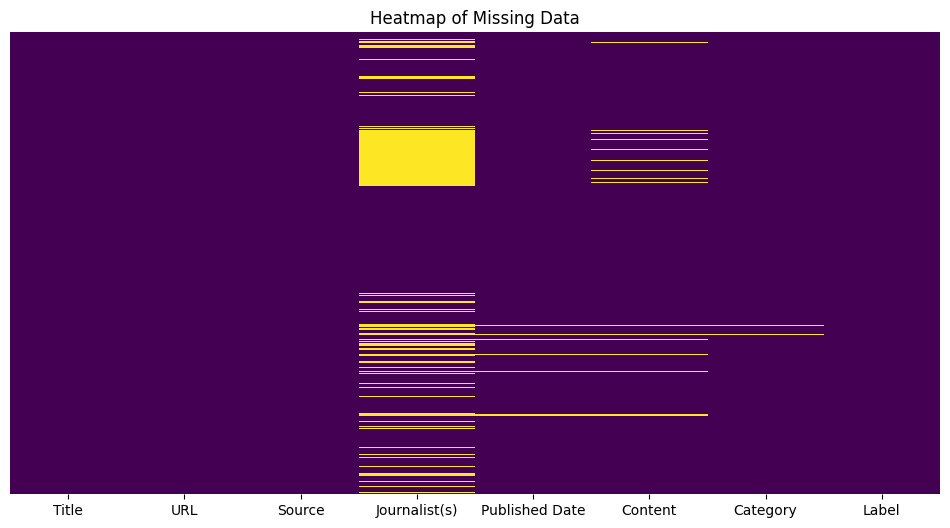

In [18]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

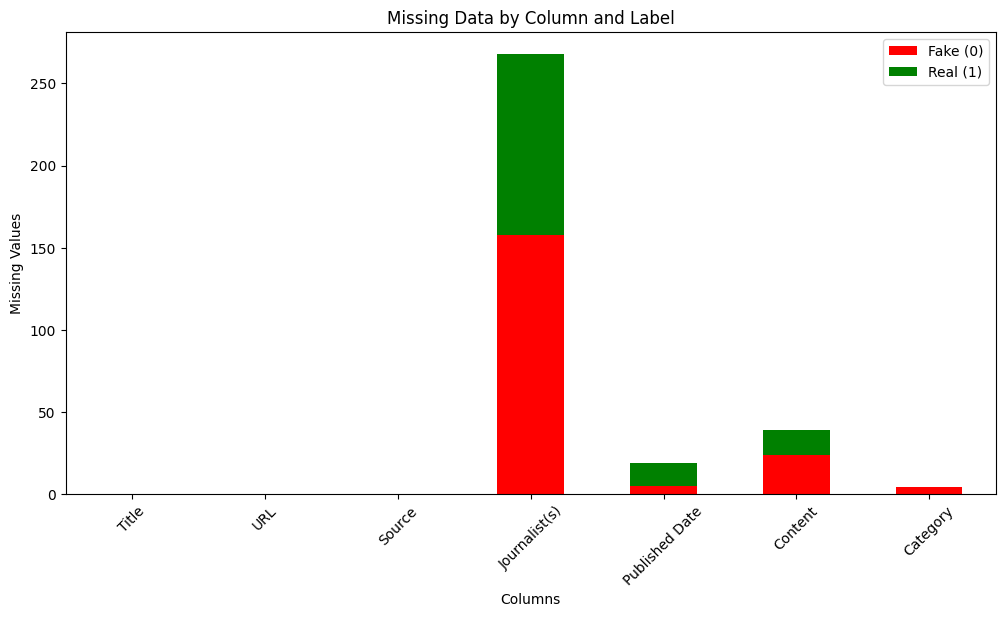

In [19]:
missing_by_label = combined_dataset.drop('Label', axis=1).groupby(combined_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

As we can see vivdly the column with the most missing data is Journalist(s).

In this case, it is acceptable not to have any listed journalists, as it is common for fake news articles to lack authors. The absence of a publication date is also not a significant issue. However, the content is a key aspect we will analyse, so when either the content or the category is missing, we can discard those rows of data.

In [20]:
cleaned_dataset = combined_dataset.dropna(subset=['Content', 'Category'])

cleaned_dataset.shape

(1048, 8)

It would be helpful to check for duplicated news titles, as I have noticed that some titles reappear multiple times. This way, we can remove them.

In [21]:
duplicate_titles = cleaned_dataset[cleaned_dataset.duplicated(subset=['Title'], keep=False)]

print(f"Number of duplicated titles: {duplicate_titles.shape[0]}")

Number of duplicated titles: 187


In [22]:
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['Title'], keep='first')

cleaned_dataset.shape

(940, 8)

In Iteration 1, I personally scraped the data, so I am familiar with most of the column information. However, to ensure everything is accurate, I am conducting a final check to confirm that the data contains only 0s and 1s. Overall, the data appears to be evenly distributed between fake and real news.

In [23]:
group_info = cleaned_dataset.groupby(["Label"])["Label"].count()
group_info

Label
0    456
1    484
Name: Label, dtype: int64

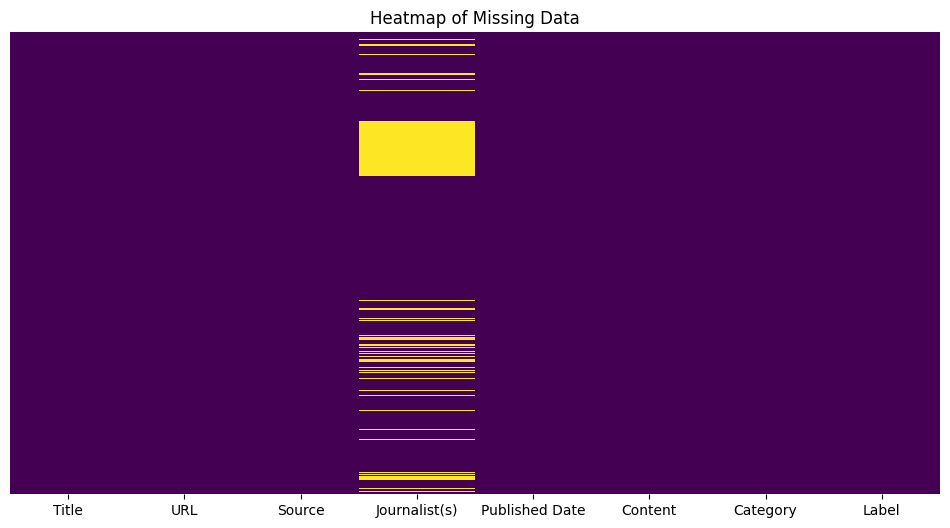

In [24]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(cleaned_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

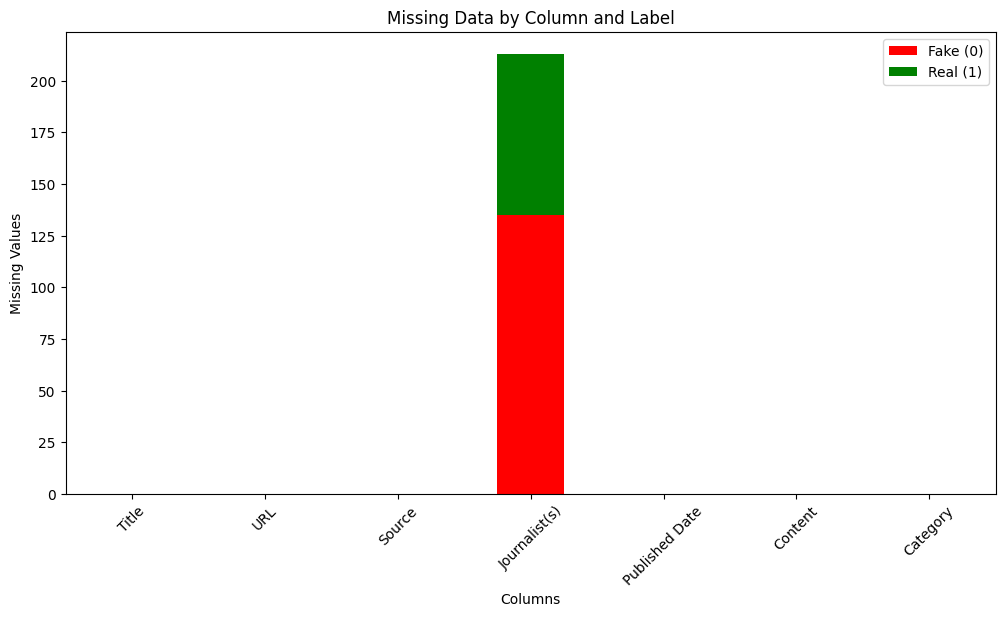

In [25]:
missing_by_label = cleaned_dataset.drop('Label', axis=1).groupby(cleaned_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

When we cleaned the Content and Category columns, we also addressed issues with the published dates. This process removed some news articles that were likely not scraped accurately, possibly due to improperly marked HTML tags. 

Currently, I believe that having no journalist listed is not a significant issue. It suggests that most articles without an identified journalist may be faulty. Therefore, I will use a decision tree model later in the notebook to assess the credibility of these articles.

In [26]:
print(f"The dataset consists of {cleaned_dataset.shape[0]} rows.")

The dataset consists of 940 rows.


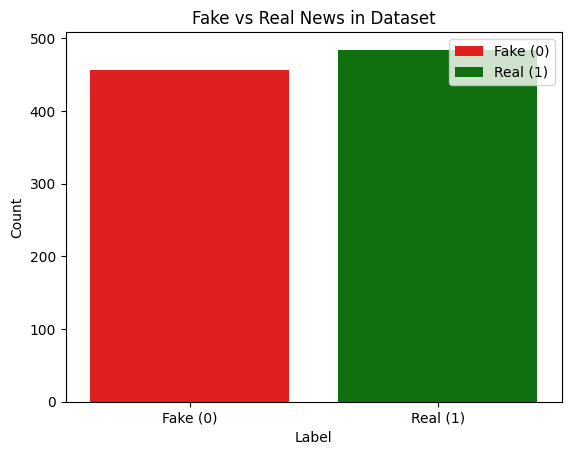

In [27]:
plt.figure()
seaborn.countplot(
    data=cleaned_dataset,
    x='Label',
    hue='Label', 
    palette={0: 'red', 1: 'green'}
)
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(['Fake (0)', 'Real (1)'])
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

Since machine learning algorithms operate exclusively with numerical data and generate numerical outputs, the first step is to ensure that the target variable is numeric. Therefore, we need to convert the `Category` variable into numbers, but first let's visualise the categories and see how much we have from each.

In [28]:
category_counts = cleaned_dataset['Category'].value_counts()

category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Count']

print(category_table)

         Category  Count
0        Politics    302
1   Entertainment    119
2          Sports    116
3      Technology    114
4      World News     80
5         Science     72
6         Economy     63
7  Human Interest     27
8           Crime     24
9     Environment     23


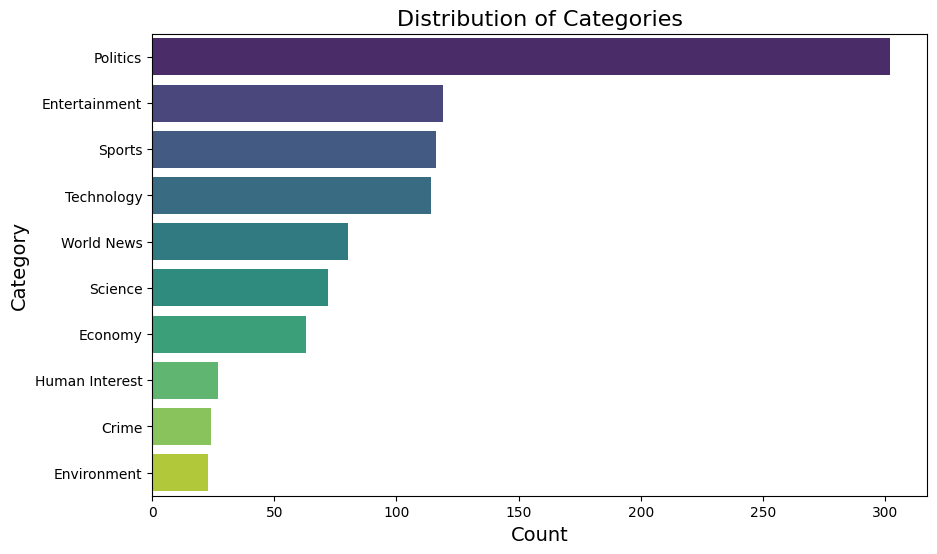

In [29]:
plt.figure(figsize=(10, 6))
seaborn.barplot(
    data=category_table,
    x='Count',
    y='Category',
    hue='Category', 
    palette='viridis'
)

plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [30]:
encoder = preprocessing.LabelEncoder()

cleaned_dataset.loc[:, "Category"] = encoder.fit_transform(cleaned_dataset["Category"])

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
3,Fauci Warns Next Pandemic May Be A Respiratory...,https://thepeoplesvoice.tv/fauci-warns-next-pa...,The People's Voice,Niamh Harris,7/4/2025,Dr Anthony Fauci has declared that the ‘next g...,6,0
15,China's dream of becoming a football superpowe...,https://www.bbc.com/news/articles/ce8vp2e7p64o,BBC,Nick Marsh,26-03-25,"On a hot, humid Thursday night in Saitama, Chi...",9,1
58,Harrison Butker Claims NFL Player of the Year ...,https://spacexmania.com/harrison-butker-claims...,SpaceXMania,Alex Bruno,26-12-24,In a stunning turn of events at the 2024 NFL A...,7,0
29,Elon Musk Takes Legal Action Against Whoopi Go...,https://spacexmania.com/elon-musk-takes-legal-...,SpaceXMania,Alex Bruno,1-01-25,Whoopi Goldberg has found herself at the cente...,2,0
139,Takeaways from APâs report on the religious ...,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,18-04-25,Superman comics are not overtly religious. Yet...,2,1
4,"Embalmers Uncover Fibrous, Rubbery Clots in 27...",https://thepeoplesvoice.tv/embalmers-uncover-r...,The People's Voice,Baxter Dmitry,7/4/2025,Embalmers worldwide are raising alarms in 2024...,6,0
1,Decision day in court for Marine Le Pen's Fren...,https://www.bbc.com/news/articles/cn91lzrrx2qo,BBC,Hugh Schofield,30-03-25,France's Marine Le Pen faces a make-or-break m...,5,1
70,Putin Survives Globalist Assassination Attempt...,https://thepeoplesvoice.tv/putin-survives-glob...,The People's Voice,Baxter Dmitry,30-03-25,One of President Vladimir Putin’s luxury limou...,5,0
26,"Canada can win trade war with US, foreign affa...",https://www.bbc.com/news/articles/cg70mknye9lo,BBC,Ana Faguy,23-03-25,Canada's Foreign Minister Mélanie Joly has tol...,5,1
7,Elon Musk Confronts BeyoncÃ© Publicly: âStop...,https://spacexmania.com/elon-musk-confronts-be...,SpaceXMania,Alex Bruno,4-02-25,"In a surprising development, tech entrepreneur...",2,0


If I had more time, I would make an effort to gather more articles by each journalist. However, since my time is limited, I prefer to focus on the decision tree idea. I believe that if an article does not have an author, it is more likely to be fake news. Therefore, let's label the articles based on whether an author is present or not.

In [31]:
print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
Alex Bruno                       149
Niamh Harris                      43
Baxter Dmitry                     31
Sean Adl-Tabatabai                24
Kyle Wiggers                      14
                                ... 
Ng Han Guan                        1
Sean O'Kane                        1
Tage Kene-Okafor                   1
Mike Butcher                       1
Lorenzo Franceschi-Bicchierai      1
Name: count, Length: 323, dtype: int64


In [32]:
cleaned_dataset['Journalist(s)'] = cleaned_dataset['Journalist(s)'].notnull().astype(int)

print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
1    727
0    213
Name: count, dtype: int64


In [33]:
aggregated_data = cleaned_dataset.groupby(['Journalist(s)', 'Label']).size().reset_index(name='Counts')

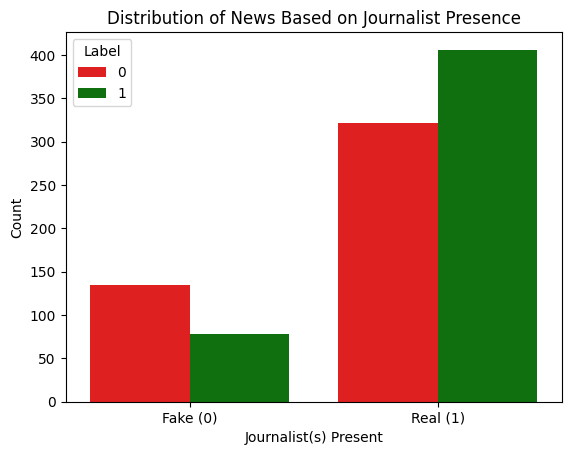

In [34]:
seaborn.barplot(
    data=aggregated_data,
    x='Journalist(s)',
    y='Counts',
    hue='Label',
    palette={0: 'red', 1: 'green'}
)
plt.title('Distribution of News Based on Journalist Presence')
plt.xlabel('Journalist(s) Present')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

### Stopwords 🛑
Stopwords are the most commonly used words in a language, such as "in," "on," "a," "an," and "the" in English. 
When evaluating whether an article is fake or not, we do not need these words, so we can choose to remove them.

In [35]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a technique that helps algorithms function more effectively. It reduces words to their root form. For instance, the words "programming" "programmer" and "programs" can all be reduced to the common word stem "program."

In [36]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

def preprocess_and_stem(text):
    # tokenize the text, convert to lowercase and remove punctuation
    tokens = word_tokenize(text.lower())
    # remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(stemmed_tokens)

In [37]:
cleaned_dataset['Title'] = cleaned_dataset['Title'].astype(str).apply(preprocess_and_stem)
cleaned_dataset['Content'] = cleaned_dataset['Content'].astype(str).apply(preprocess_and_stem)

print(cleaned_dataset[['Title', 'Content']].head())

                                               Title  \
0     istanbul mayor arrest ahead select run erdogan   
1    kill gaza sinc israel offens began ministri say   
2              ferrari hamilton disqualifi chines gp   
3            life spent wait search row unclaim bodi   
5  us hope progress peac talk three kill russian ...   

                                             Content  
0  main rival turkey presid recep tayyip erdogan ...  
1  palestinian kill israel militari campaign gaza...  
2  lewi hamilton finish sixth chines grand prix s...  
3  saira baloch 15 step morgu first time heard ro...  
5  imogen jamesl report upcom peac talk ukrain wa...  


### Word Cloud ☁️
Let's visualise the most used words in both fake and real media, when it comes to the `Title` and `Content` of the news.

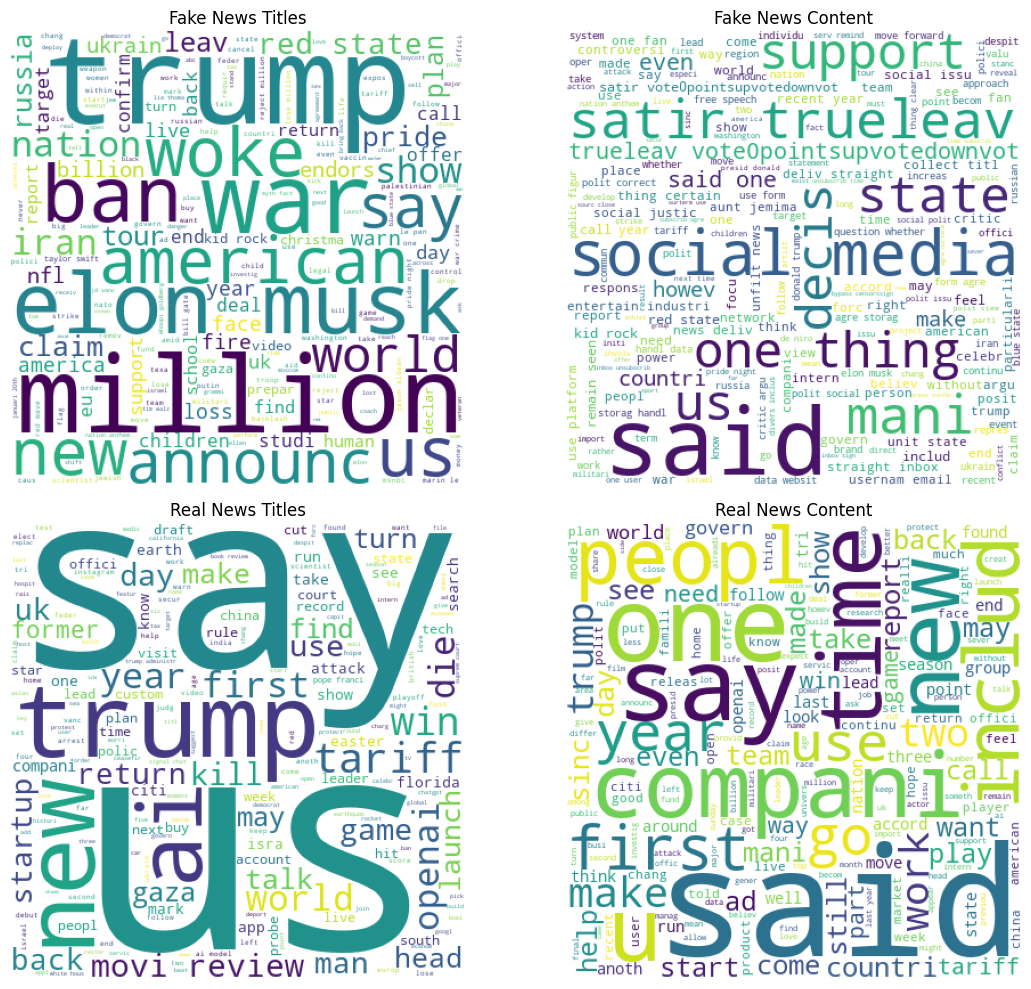

In [38]:
real_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Title'])
fake_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Title'])

real_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Content'])
fake_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Content'])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# titles comparison
ax[0, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_titles))
ax[0, 0].set_title("Fake News Titles")
ax[0, 0].axis('off')

ax[1, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_titles))
ax[1, 0].set_title("Real News Titles")
ax[1, 0].axis('off')

# content comparison
ax[1, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_content))
ax[1, 1].set_title("Real News Content")
ax[1, 1].axis('off')

ax[0, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_content))
ax[0, 1].set_title("Fake News Content")
ax[0, 1].axis('off')

plt.tight_layout()
plt.show()

In comparison to Iteration 0, in Iteration 1 we can see more recent words that appear in current media, such as "tariff" and "Trump"; there is no mention of "Hillary Clinton" anymore. To summarize:

| **News**   | **Titles**                                                                                          | **Content**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | Big, dramatic words like "million", "war" and "woke" and names of famous people like "Trump", "Elon" and "Musk". | Focus on opinions, social media and words like "support", "satire" and "true". Less about facts, more about feelings or controversy. |
| **Real**   | Words about real events and places like "kill", "win", "Gaza", "Ukraine", "tariff" and "Trump". More factual and direct. | Focus on people, facts and explanations. Common words are "one", "people", "say", "year" and "country." More neutral and informative. |


### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models like K-NN and Naive Bayes to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as real (1) or fake (0).

In [39]:
vectorizer_title = TfidfVectorizer()
vectorizer_content = TfidfVectorizer()

X_title = vectorizer_title.fit_transform(cleaned_dataset['Title']).toarray()
X_content = vectorizer_content.fit_transform(cleaned_dataset['Content']).toarray()

print("Title TF-IDF shape:", X_title.shape)
print("Content TF-IDF shape:", X_content.shape)

Title TF-IDF shape: (940, 3135)
Content TF-IDF shape: (940, 22351)


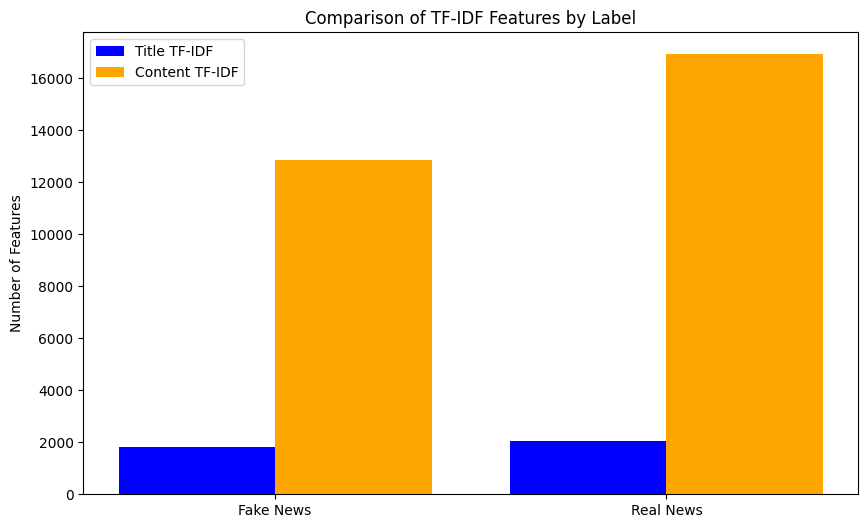

In [40]:
# split by label
fake_titles = cleaned_dataset[cleaned_dataset['Label'] == 0]['Title']
real_titles = cleaned_dataset[cleaned_dataset['Label'] == 1]['Title']

fake_contents = cleaned_dataset[cleaned_dataset['Label'] == 0]['Content']
real_contents = cleaned_dataset[cleaned_dataset['Label'] == 1]['Content']

# transform separately for fake and real data
fake_title_tfidf = vectorizer_title.fit_transform(fake_titles).shape[1]
real_title_tfidf = vectorizer_title.fit_transform(real_titles).shape[1]

fake_content_tfidf = vectorizer_content.fit_transform(fake_contents).shape[1]
real_content_tfidf = vectorizer_content.fit_transform(real_contents).shape[1]

# bar plot
labels = ['Fake News', 'Real News']
title_features = [fake_title_tfidf, real_title_tfidf]
content_features = [fake_content_tfidf, real_content_tfidf]

x = range(len(labels))

plt.figure(figsize=(10, 6))

# title features
plt.bar(x, title_features, width=0.4, label='Title TF-IDF', color='blue', align='center')
# content features
plt.bar([p + 0.4 for p in x], content_features, width=0.4, label='Content TF-IDF', color='orange', align='center')

plt.xticks([p + 0.2 for p in x], labels)
plt.title('Comparison of TF-IDF Features by Label')
plt.ylabel('Number of Features')
plt.legend()
plt.show()


| **Label**   | **Title TF-IDF Features**                                                                                          | **Content TF-IDF Features**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | ~1,800 | ~13,000 |
| **Real**   | ~2,000 | ~17,000 |

- **Content Richness:** Real News articles tend to be longer and more detailed, resulting in a greater diversity of terms and consequently, more TF-IDF features. Fake News articles, by contrast, may be shorter or use a more limited vocabulary.
- **Title Brevity:** Titles, regardless of label, yield far fewer features due to the imited word count.

### Combine the features 🥣
Combine the title and content into one feature matrix.

For Iteration 2, I decided to implement the journalists idea so let's implement it.

In [41]:
journalist_feature = cleaned_dataset['Journalist(s)'].values.reshape(-1, 1)

In [42]:
X = numpy.hstack((X_title, X_content, journalist_feature))

### Target variable 🎯 
The target variable is obviously `Label`.

In [43]:
y = cleaned_dataset['Label']

### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 940 observations, of which 752 are now in the train set and 188 in the test set.


### Modelling 🧬

For iteration 0, I used K-NN for iteration 0 and now, for Iteration 1 - Naive Bayes. The test set will be used to calculate the model's accuracy, which indicates how well it performs. 

Now for Iteration 2 - Decision Trees.
First, we need to separate the Journalist(s) feature for training the Decision Tree.

In [45]:
X_train_journalist = X_train[:, -1].reshape(-1, 1) # extract last column
X_test_journalist = X_test[:, -1].reshape(-1, 1)

Then we train Multinomial Naive Bayes for title and content features.

In [46]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train[:, :-1], y_train)  # exclude the last column
y_pred_nb = clf_nb.predict(X_test[:, :-1])

Training the Decision Tree Classifier for Journalist(s) feature.

In [47]:
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train_journalist, y_train)
y_pred_tree = clf_tree.predict(X_test_journalist)

We then combine predictions (e.g., weighted average or voting). Here, let's use a simple majority vote for demonstration purposes:

In [48]:
y_pred_combined = (y_pred_nb + y_pred_tree) > 1  # majority vote logic

In [49]:
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy of Combined Model: {accuracy_combined * 100:.2f}%")

Accuracy of Combined Model: 89.89%


The accuracy of Naive Bayes is approximately 90.43%, which is higher than K-NN - 85.68%.

When Decision Trees was added it lowered down to 89.89%.

## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

In [50]:
print(classification_report(y_test, y_pred_combined))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       107
           1       0.96      0.80      0.87        81

    accuracy                           0.90       188
   macro avg       0.91      0.89      0.89       188
weighted avg       0.91      0.90      0.90       188



It is important to consider the confusion matrix when evaluating a model's performance. The overall accuracy of the model is 89%. The F1-scores for both classes are close (0.92 vs. 0.87), indicating balanced performance with no severe bias toward either class.

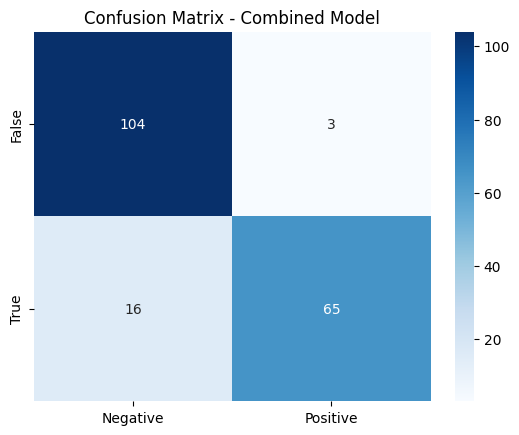

In [51]:
cm = confusion_matrix(y_test, y_pred_combined)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Combined Model')
plt.show()

This time, the false positives are fewer than the true negatives, which has been the desired goal since Iteration 0. In my opinion, it is better to classify more true news as fake than to classify fake news as truthful.

## Website 🌐

In [52]:
joblib.dump(clf_nb, 'website/models/naive_bayes_model.pkl')

['website/models/naive_bayes_model.pkl']

In [53]:
joblib.dump(vectorizer_title, 'website/models/vectorizer_title.pkl')
joblib.dump(vectorizer_content, 'website/models/vectorizer_content.pkl')

['website/models/vectorizer_content.pkl']

In [54]:
joblib.dump(clf_tree, 'website/models/decision_tree_model.pkl')

['website/models/decision_tree_model.pkl']